# Advanced techniques

Let's explore feature engineering techniques with the house prices dataset from Kaggle.

We can find an illustrative example of how to use Deep feature synthesis [here](https://www.kaggle.com/willkoehrsen/featuretools-for-good), and a good explanation [here](https://stackoverflow.com/questions/52418152/featuretools-can-it-be-applied-on-a-single-table-to-generate-features-even-when).

<h1>Table of Contents<span class="tocSkip"></span></h1>
<div class="toc"><ul class="toc-item"><li><span><a href="#Advanced-techniques" data-toc-modified-id="Advanced-techniques-1"><span class="toc-item-num">1&nbsp;&nbsp;</span>Advanced techniques</a></span><ul class="toc-item"><li><span><a href="#Setup-the-dataset" data-toc-modified-id="Setup-the-dataset-1.1"><span class="toc-item-num">1.1&nbsp;&nbsp;</span>Setup the dataset</a></span><ul class="toc-item"><li><span><a href="#Check-correlation" data-toc-modified-id="Check-correlation-1.1.1"><span class="toc-item-num">1.1.1&nbsp;&nbsp;</span>Check correlation</a></span></li><li><span><a href="#Check-skewness" data-toc-modified-id="Check-skewness-1.1.2"><span class="toc-item-num">1.1.2&nbsp;&nbsp;</span>Check skewness</a></span></li><li><span><a href="#Under-represented-features" data-toc-modified-id="Under-represented-features-1.1.3"><span class="toc-item-num">1.1.3&nbsp;&nbsp;</span>Under represented features</a></span></li></ul></li><li><span><a href="#Build-the-EntitySet" data-toc-modified-id="Build-the-EntitySet-1.2"><span class="toc-item-num">1.2&nbsp;&nbsp;</span>Build the EntitySet</a></span><ul class="toc-item"><li><span><a href="#Normalize-the-entity" data-toc-modified-id="Normalize-the-entity-1.2.1"><span class="toc-item-num">1.2.1&nbsp;&nbsp;</span>Normalize the entity</a></span></li><li><span><a href="#Deep-feature-synthesis" data-toc-modified-id="Deep-feature-synthesis-1.2.2"><span class="toc-item-num">1.2.2&nbsp;&nbsp;</span>Deep feature synthesis</a></span></li></ul></li></ul></li></ul></div>

## Setup the dataset

In [1]:
import nbimporter
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import scipy.stats as ss
import seaborn as sns
import warnings

from scipy.stats import skew, boxcox_normmax
from scipy.special import boxcox1p

warnings.filterwarnings('ignore')
warnings.simplefilter(action='ignore', category=FutureWarning)
warnings.simplefilter(action='ignore', category=DeprecationWarning)

from src.dataset import Dataset

In [2]:
houses = Dataset('./data/houseprices_prepared.csv.gz')
houses.describe()


Available types: [dtype('int64') dtype('O') dtype('float64')]
80 Features
43 categorical features
37 numerical features
16 categorical features with NAs
0 numerical features with NAs
64 Complete features
--
Target: Not set


We will replace the NA's in the dataset with 'None' or 'Unknown' since they're not really NA's. For no good reason the person in charge of encoding the file decided to assign NA's to values where the feature does not apply, but instead of using a value for that special condition (like the string 'None') he/she decided to use the actual NA.

In [3]:
houses.replace_na(column='Electrical', value='Unknown')
houses.replace_na(column=houses.names('categorical_na'), value='None')
houses.set_target('SalePrice')
houses.describe()


Available types: [dtype('int64') dtype('O') dtype('float64')]
79 Features
43 categorical features
36 numerical features
0 categorical features with NAs
0 numerical features with NAs
79 Complete features
--
Target: SalePrice


### Check correlation

There are 3 correlated columns to remove.
['1stFlrSF', 'TotRmsAbvGrd', 'GarageArea']


/Users/renero/Code/anaconda3/lib/python3.6/site-packages/seaborn/palettes.py:777: DeprecationWarning: object of type <class 'float'> cannot be safely interpreted as an integer.
  pal = _ColorPalette(pal(np.linspace(0, 1, n_colors)))


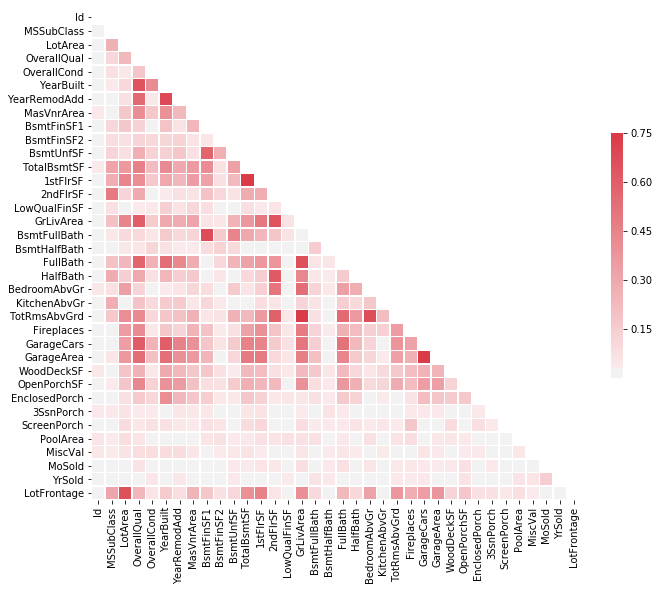

In [4]:
numericals_to_drop, corr_num = houses.numerical_correlated(threshold=0.7)
print('There are {} correlated columns to remove.'.format(
    len(numericals_to_drop)))
print(numericals_to_drop)
houses.plot_corr_matrix(corr_num)

There are 2 correlated columns to remove.
['Exterior2nd', 'GarageCond']


/Users/renero/Code/anaconda3/lib/python3.6/site-packages/seaborn/palettes.py:777: DeprecationWarning: object of type <class 'float'> cannot be safely interpreted as an integer.
  pal = _ColorPalette(pal(np.linspace(0, 1, n_colors)))


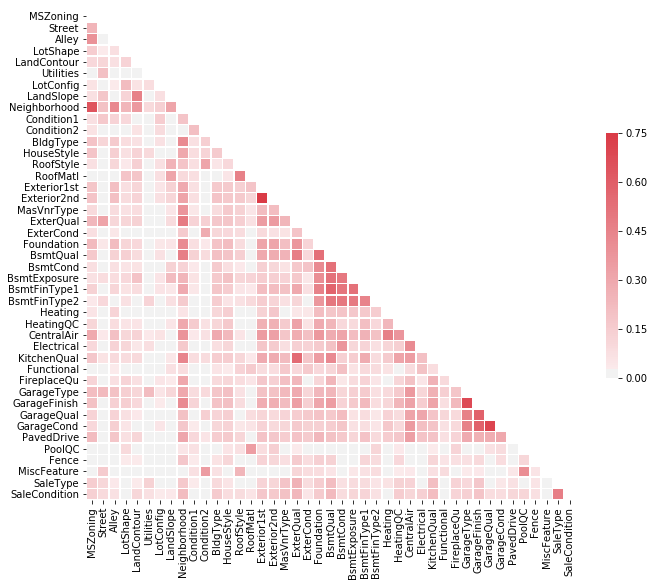

In [5]:
categoricals_to_drop, corr_categ = houses.categorical_correlation(threshold=0.7)
print('There are {} correlated columns to remove.'.format(
    len(categoricals_to_drop)))
print(categoricals_to_drop)
houses.plot_corr_matrix(corr_categ)

In [6]:
houses.drop_columns(categoricals_to_drop + numericals_to_drop)
houses.describe()


Available types: [dtype('int64') dtype('O') dtype('float64')]
74 Features
41 categorical features
33 numerical features
0 categorical features with NAs
0 numerical features with NAs
74 Complete features
--
Target: SalePrice


### Check skewness

In [13]:
houses.skewness(fix=True, return_series=False)

### Under represented features

In [5]:
urf = houses.under_represented_features()
print('Features with unrepresented categories:\n', urf)
houses.drop_columns(urf)
print(end='')
houses.describe();

Features with unrepresented categories:
 []

Available types: [dtype('int64') dtype('O') dtype('float64')]
74 Features
38 categorical features
36 numerical features
0 categorical features with NAs
0 numerical features with NAs
74 Complete features
--
Target: SalePrice


## Build the EntitySet

In [19]:
import featuretools as ft

es = ft.EntitySet()
es = es.entity_from_dataframe(entity_id='houses', 
                              dataframe=houses.data,
                              index = 'Id')
es

Entityset: None
  Entities:
    houses [Rows: 1460, Columns: 74]
  Relationships:
    No relationships

### Normalize the entity

In [20]:
es.normalize_entity(base_entity_id='houses', 
                    new_entity_id='houses_norm',
                    additional_variables = houses.names('all').remove('Id'),
                    index='Id')
es

Entityset: None
  Entities:
    houses [Rows: 1460, Columns: 74]
    houses_norm [Rows: 1460, Columns: 1]
  Relationships:
    houses.Id -> houses_norm.Id

### Deep feature synthesis

In [21]:
f_matrix, f_defs = ft.dfs(entityset=es,
                          target_entity='houses_norm', 
                          verbose=1,
                          n_jobs=-1)

Built 274 features
EntitySet scattered to workers in 3.201 seconds
Elapsed: 00:12 | Remaining: 00:00 | Progress: 100%|██████████| Calculated: 10/10 chunks

Exception ignored in: <generator object add_client at 0x1c272cd410>
RuntimeError: generator ignored GeneratorExit
tornado.application - ERROR - Exception in Future <Future cancelled> after timeout
Traceback (most recent call last):
  File "/Users/renero/Code/anaconda3/lib/python3.6/site-packages/tornado/gen.py", line 970, in error_callback
    future.result()
concurrent.futures._base.CancelledError


remove new variables related to the target

In [22]:
drop_cols = []
for col in f_matrix:
    if col == houses.names('target'):
        pass
    else:
        if houses.names('target') in col:
            drop_cols.append(col)
            
print('Need to drop columns:', drop_cols)
f_matrix = f_matrix[[x for x in f_matrix if x not in drop_cols]]

Need to drop columns: []


In [26]:
houses.names('target')

'SalePrice'